#### Neural Network Introduction

Jay Urbain, PhD

1/20/2019, 1/31/2019

Credits: 
- [Calculus on Computational Graphs: Backpropagation, C. Olah](http://colah.github.io/posts/2015-08-Backprop/)  
- [CNN Class, A. Karpathy](http://cs231n.github.io/optimization-2/)  
- [Machine Learning Mastery, Jason Brownlee](https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/)     
- [Denny Britz, wildml.com](wildml.com)     

#### Neural Network Introduction

Develop a 3-layer neural network to provide a foundational understanding of neural networks without excessive math details.
 
Implementing a basic network is a valuable exercise for gaining a better understanding of how neural networks work, and that understanding is essential to designing effective models.

In practice, many fine neural network libraries are available for developing an deploying more complex solutions.

Compatibility: Developed using Python 3.6 with the packages listed in the next cell.

In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

#### Generate a dataset

[scikit-learn](http://scikit-learn.org/) has useful dataset generators. Use the [`make_moons`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function to generate a dataset with a non-linear decision boundary.

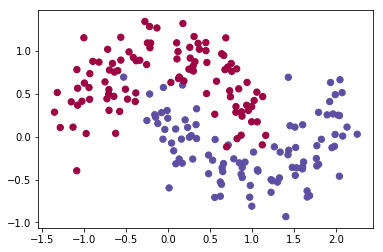

In [2]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

The dataset has two classes, plotted as red and blue points. You can think of the blue dots as male patients and the red dots as female patients, with the x- and y-axis being medical measurements. 

Our goal is to train a Machine Learning classifier that predicts the correct class red/blue (male/female) given the x- and y-values. It's important to note that the data is not *linearly separable*, i.e., we can't draw a straight line that separates the two classes. This means that linear classifiers, such as *Logistic Regression*, won't be able to fit the data unless you hand-engineer non-linear features (such as polynomials) that work well for the given dataset.

That's one of the major advantages of Neural Networks. You don't need to peform [feature engineering](http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/). 

The hidden layer(s) of a neural network are capable of learning a hierarchical representation of the features.

#### Logistic Regression

To illustrate the idea of a linearly seperaple classifier, train a Logistic Regression classifier. The input will be the x- and y-values and the output the predicted class (0 or 1). We will use the Logistic Regression classifier from `scikit-learn`.

In [3]:
# Train the logistic regeression classifier using cross-validation
clf = sklearn.linear_model.LogisticRegressionCV(cv=5)
clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [4]:
# Helper function to plot a decision boundary. 

def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

Text(0.5,1,'Logistic Regression')

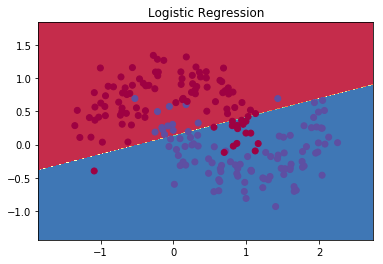

In [5]:
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

The graph shows the decision boundary learned by the Logistic Regression classifier. It separates the data as good as it can using a straight line, but it's unable to capture the non-linear "moon shape" of the data. A neural network is well suited for capturing these non-linear decision boundaries.

#### Training a Neural Network

Build a 3-layer neural network with one input layer, one hidden layer, and one output layer. The number of nodes in the input layer is determined by the dimensionality of our input data which is 2. 

The number of nodes in the output layer is determined by the number of classes we have which is two (male, female). *Note: since we only have 2 classes we could use one output node predicting 0 or 1. Having 2 nodes makes it easier to extend the network to more classes later on*. 

The input to the network will be x- and y-values, and its output will be two probabilities, one for class 0 ("female") and one for class 1 ("male"). 

We can select the dimensionality (the number of nodes) of the hidden layer. In most applications, this is an important decision and typically requires a significant number of iterations to identify the optimal set of hidden nodes.

The more nodes we add to the hidden layer, the more complex the function that we will be able to fit to the data. Higher dimensionality comes at a cost of increased complexity in our model, i.e., increased variances, reduced bias, and an increased tendency to overfit our data.  In addition, models with larger number of parameters can take signficantly longer to train.

However, if we select too few hidden nodes, we may have too much bias and our model will underfit the data. 

How to choose the size of the hidden layer? It depend on your application, but a good starting point is to take the halfway mark between the number of input and output nodes. You should still evaluate different selections of hidden nodes on a validation set.

We also need to pick an *activation function* for our hidden layer. The activation function transforms the inputs to each node (at each layer) into its outputs. A nonlinear activation function is what allows us to fit a nonlinear model. Common chocies for activation functions are [tanh](https://reference.wolfram.com/language/ref/Tanh.html), the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function), or [ReLUs] (https://en.wikipedia.org/wiki/Rectifier_(neural_networks). 

We will use $tanh$, which performs well in many scenarios. The derivative of $\tanh x$ is $(1-\tanh^2 x)$. This is useful because it allows us to compute $\tanh x$ once and re-use its value later on to get the derivative.

Because we want our network to output probabilities, the activation function for the output layer will be the [softmax](https://en.wikipedia.org/wiki/Softmax_function) function, which is a standard method to convert raw scores to probabilities. Softmax as a generalization of logistic regression to multiple classes. Softmax:

$\sigma(\mathbf{z})_j = \frac{e^{\beta z_j}}{\sum_{k=1}^K e^{\beta z_k}}$ *&nbsp;&nbsp; &nbsp;&nbsp; for 'j' = 1, …, 'K'.*




#### Making predictions

The network makes predictions using *forward propagation*, which is an application of the vector dot product of the output of all nodes from the previous layer and the edge weights connecting each node in a subsequent layer. This sum of products is used as input to the node activation function. If $X$ is the 2-dimensional input to our network then we calculate our prediction $\hat{Y}$ (also two-dimensional vector) as follows:

$$
\begin{aligned}
Z_1 & = XW_1 + b_1 \\
A_1 & = \tanh(Z_1) \\
Z_2 & = A_1W_2 + b_2 \\
A_2 & = \hat{Y} = \mathrm{softmax}(Z_2)
\end{aligned}
$$

$Z_i$ is the input of layer $i$ and $A_i$ is the output of layer $i$ after applying the activation function. $W_1, b_1, W_2, b_2$ are  parameters of our network, which we need to learn from our training data. 

$W_1, b_1$ represent the weights and bias between the input layer and the hidden layer. $W_2, b_2$ represent the weights and bias between the hidden layer and the output layer.

Looking at the matrix multiplications above, we can figure out the dimensionality of these matrices. If we use 500 nodes for our hidden layer, then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. You can see how adding more parameters can quickly increase the size of the hidden layer.

### Learning the Parameters

Learning the parameters for our network means finding parameters ($W_1, b_1, W_2, b_2$) that minimize the error on our training data. We call the function that measures our error the *loss function*. A common choice with the softmax output is the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression). If we have $N$ training examples and $C$ classes then the loss for our prediction $\hat{Y}$ with respect to the true labels $Y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$



The further the distance between $y$ (the correct labels) and $\hat{y}$ (our predictions), the greater our loss will be. 

*Note: For regression, we could have used mean-square-error.*

Our goal is to find the parameters that minimize our loss function. We can use [gradient descent](http://cs231n.github.io/optimization-1/) to find its minimum. We will implement a basic version of gradient descent called batch gradient descent with a fixed learning rate. Variations such as SGD (stochastic gradient descent) or minibatch gradient descent typically perform better in practice. See [decay the learning rate over time](http://cs231n.github.io/neural-networks-3/#anneal).

As an input, gradient descent needs the gradients (vector of derivatives) of the loss function with respect to our parameters: $\frac{\partial{L}}{\partial{W_1}}$, $\frac{\partial{L}}{\partial{b_1}}$, $\frac{\partial{L}}{\partial{W_2}}$, $\frac{\partial{L}}{\partial{b_2}}$. 

To calculate these gradients we use the *backpropagation algorithm*, which is a way to efficiently calculating the gradients starting from the output. ([Backpropagation](http://colah.github.io/posts/2015-08-Backprop/) or [here](http://cs231n.github.io/optimization-2/)).

Applying the backpropagation formula we find the following partial derivatives for our gradients:

$$
\begin{aligned}
& \delta_3 = Y - \hat{Y} \\
& \delta_2 = (1 - \tanh^2Z_1) \circ \delta_3W_2^T \\
& \frac{\partial{L}}{\partial{W_2}} = A_1^T \delta_3  \\
& \frac{\partial{L}}{\partial{b_2}} = \delta_3\\
& \frac{\partial{L}}{\partial{W_1}} = X^T \delta_2\\
& \frac{\partial{L}}{\partial{b_1}} = \delta_2 \\
\end{aligned}
$$

#### Implementation

Start by defining some useful hyperparameters for gradient descent:

In [6]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

#### Loss function

In [7]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1 
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    
    # softmax
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    correct_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(correct_logprobs)
    
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

#### Prediction function

Perform forward propagation and return the class with the highest probability.

In [8]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

#### Backpropagation

Build model.

In [9]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. 
    # These are the parameters we need to learn.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print ("Loss after iteration %i: %f" %(i, calculate_loss(model)) )
    
    return model

#### Build a network with a hidden layer of size 3

Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.068890
Loss after iteration 3000: 0.071218
Loss after iteration 4000: 0.071253
Loss after iteration 5000: 0.071278
Loss after iteration 6000: 0.071293
Loss after iteration 7000: 0.071303
Loss after iteration 8000: 0.071308
Loss after iteration 9000: 0.071312
Loss after iteration 10000: 0.071314
Loss after iteration 11000: 0.071315
Loss after iteration 12000: 0.071315
Loss after iteration 13000: 0.071316
Loss after iteration 14000: 0.071316
Loss after iteration 15000: 0.071316
Loss after iteration 16000: 0.071316
Loss after iteration 17000: 0.071316
Loss after iteration 18000: 0.071316
Loss after iteration 19000: 0.071316


Text(0.5,1,'Decision Boundary for hidden layer size 3')

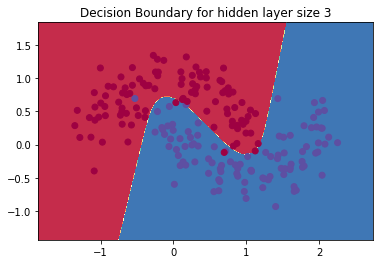

In [10]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

Our neural networks should have been able to find a decision boundary that successfully separates the classes.

### Exercises

#### 1) Varying the hidden layer size

In the example above we picked a hidden layer size of 3 and trained on all of the data $X$. 

Create separate training (0.80) and validation (0.20) sets from the moon dataset generated at the begining of the notebook.

For a learning rate = 0.1 and 10,000 iterations, utilize the code below to write and execute a function to evaluate hidden layer dimensions (number of nodes in the hidden layer) in the set [3, 20, 50]. For each evaluation, list the final loss, and plot the decision boundary using the plot_decision_boundary() function defined above.


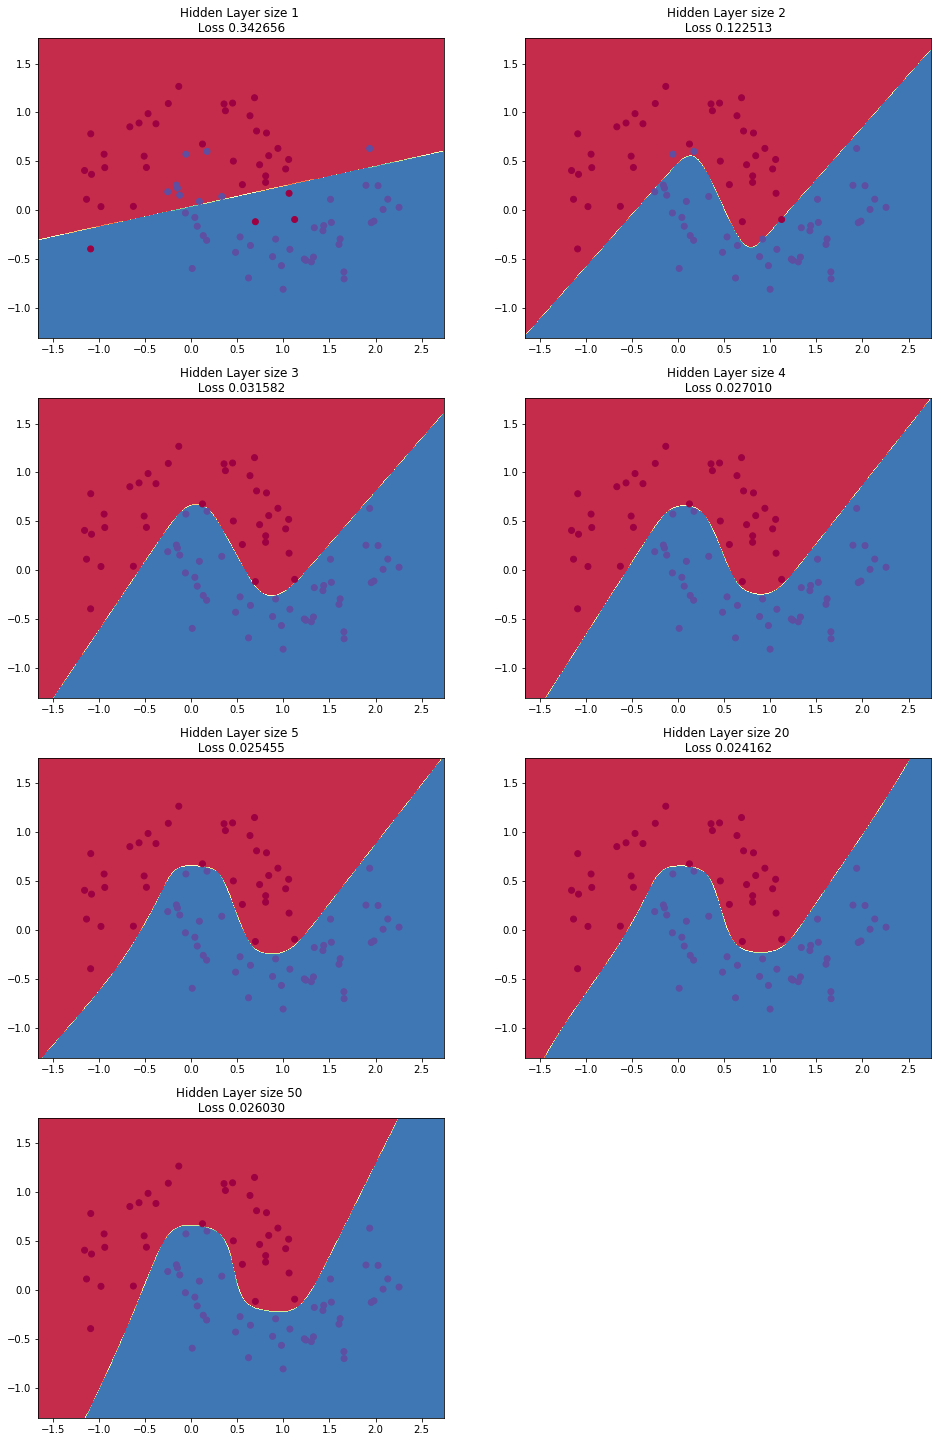

In [24]:
from sklearn.model_selection import train_test_split

X_base = X
y_base = y

X, X_test, y, y_test = train_test_split(X_base, y_base, test_size=0.2, random_state=1)

num_examples = len(X)

plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    model = build_model(nn_hdim, num_passes=10000)
    plot_decision_boundary(lambda x: predict(model, x))
    plt.title('Hidden Layer size %d \n Loss %f ' % (nn_hdim, calculate_loss(model)) )
plt.show()

You should see how a hidden layer of low dimensionality nicely captures the general trend of our data, but higher dimensionalities are prone to overfitting. High dimensionality models are "memorizing" the data as opposed to fitting the general shape. 

If we evaluate our model on a separate validation set the model with a smaller hidden layer size, we would likely perform better because it generalizes better. We can counteract overfitting with stronger regularization.

**Note:** The optimal hidden layer size seems to be 3 as there is a significant improvementr from hidden layer size of 2 to 3 however after that the additional layers provide deminishing returns which are a sign of overfitting

#### 2) Identify the learning rate

Using the optimal number of hidden nodes identified in  (1) above, identify the optimal learning rate from the set (0.3, 0.1, 0.01, 0.001).


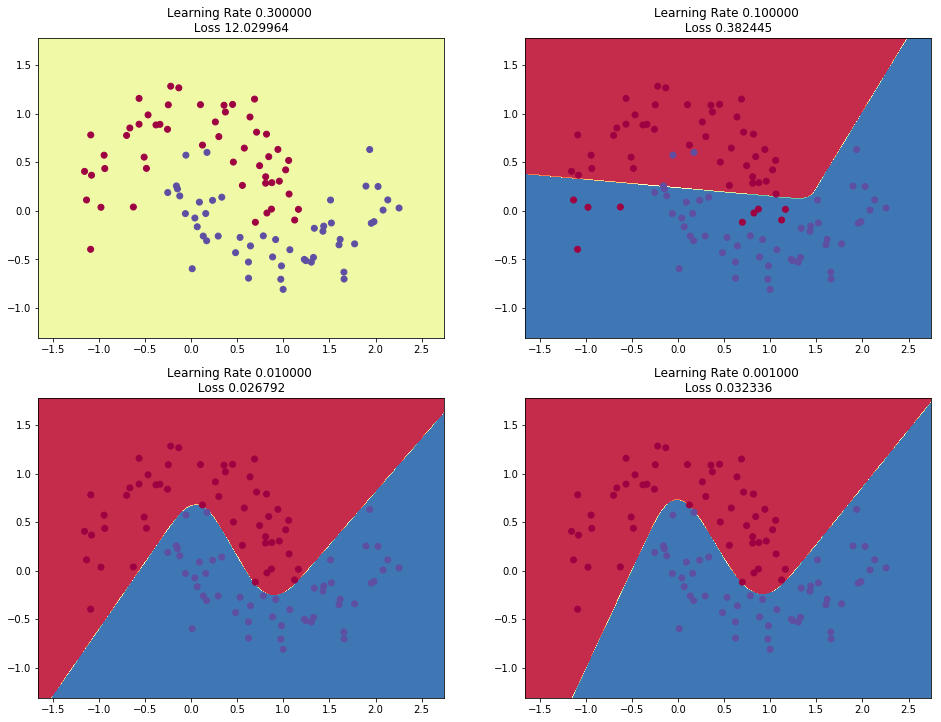

In [20]:
plt.figure(figsize=(16, 32))
learning_rate = [0.3, 0.1, 0.01, 0.001]
nn_hdim = 3
for i, e in enumerate(learning_rate):
    plt.subplot(5, 2, i+1)
    epsilon = e
    model = build_model(nn_hdim, num_passes=10000)
    plot_decision_boundary(lambda x: predict(model, x))
    plt.title('Learning Rate %f \n Loss %f ' % (epsilon, calculate_loss(model)) )
plt.show()

**Note:** From the anove graphs we can clearly see that the optimal learning rate is 0.01

#### 3) Identify the optimal number of training epochs

Using the optimal number of hidden nodes identified in (1) and the optimal learning rate (2), 
identify the optimal number of training epochs.

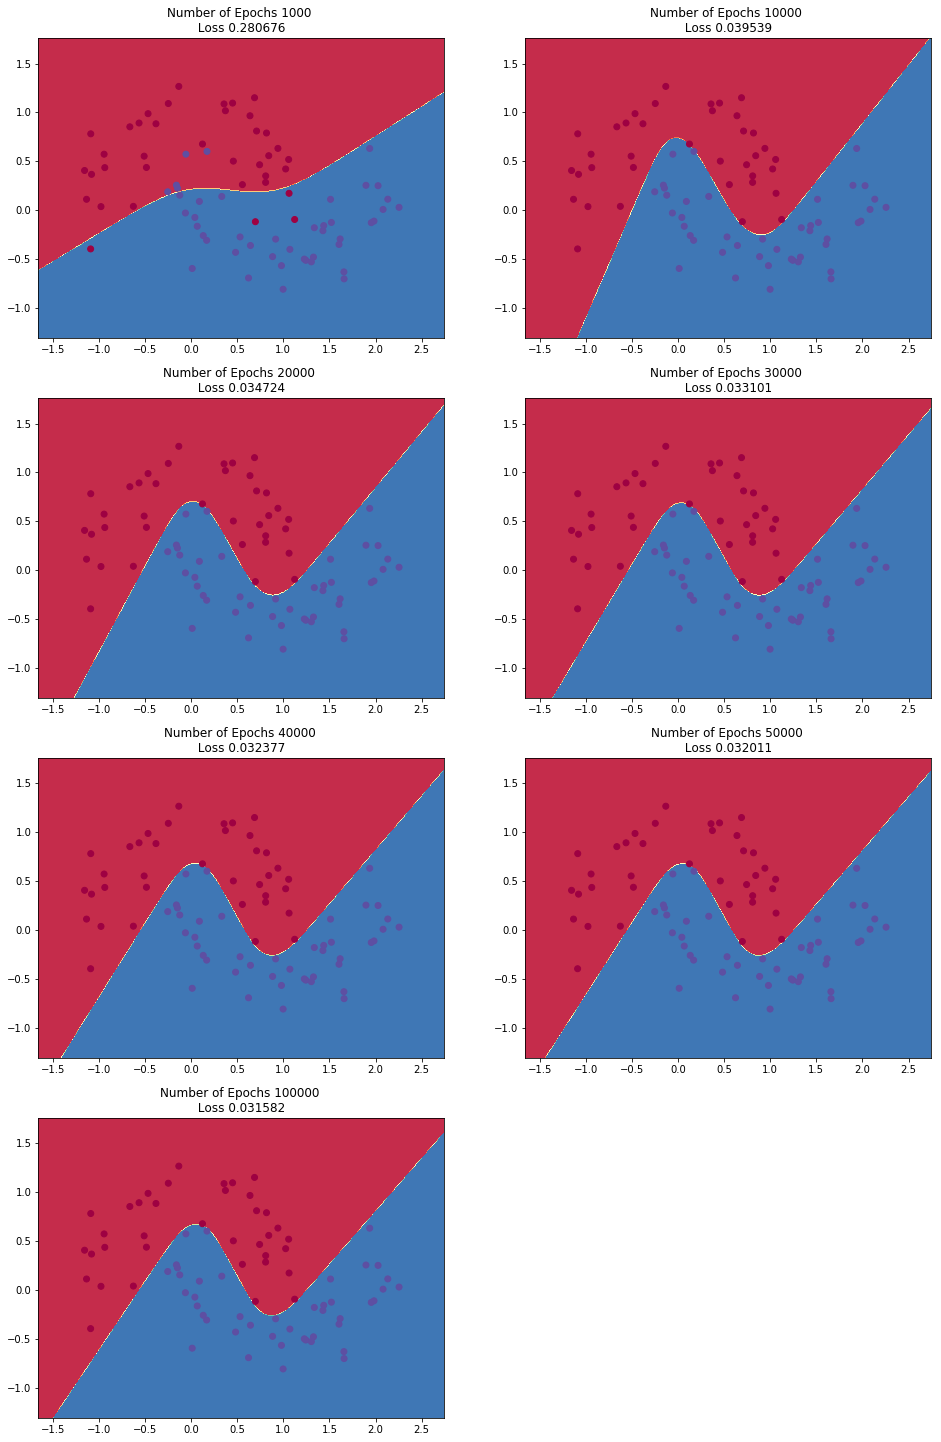

In [25]:
plt.figure(figsize=(16, 32))
number_of_epochs = [1000, 10000, 20000, 30000, 40000, 50000, 100000]
nn_hdim = 3
epsilon = 0.01
for i, epochs in enumerate(number_of_epochs):
    plt.subplot(5, 2, i+1)
    epsilon = e
    model = build_model(nn_hdim, num_passes=epochs)
    plot_decision_boundary(lambda x: predict(model, x))
    plt.title('Number of Epochs %d \n Loss %f ' % (epochs, calculate_loss(model)) )
plt.show()

**Note:** From the above graphs it can be seen that the ideal number of epochs is around 20,000

#### Extra credit:

1. Evaluate the performance of your updated network using a logistic (sigmoid) or ReLU furncion. Use the optimal hyperparameters from 1, 2, and 3.        
2. Instead of batch gradient descent, use minibatch gradient descent ([more info](http://cs231n.github.io/optimization-1/#gd)) to train the network. Minibatch gradient descent typically performs better in practice. 
2. We used a fixed learning rate $\epsilon$ for gradient descent. Implement an annealing schedule for the gradient descent learning rate ([more info](http://cs231n.github.io/neural-networks-3/#anneal)). 
4. Extend the network from two to three or more classes. You will need to generate an appropriate dataset for this.
5. Extend the network to four layers. Experiment with the layer size. Adding another hidden layer means you will need to adjust both the forward propagation as well as the backpropagation code.